In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

from itertools import product
import pandas as pd
import torch
import torch.nn.functional as F
from torch_sparse.tensor import SparseTensor
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind

from src.train.gcn_node_classifier import GCNNodeClassifierTrainer
from src.torch_geo_models import GCN
from src.data.node_classifier.arxiv import load_dataset_pyg,\
    data_to_sparse_symmetric_pyg, get_edge_weights_pyg

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read metrics

In [3]:
metrics = GCNNodeClassifierTrainer.read_metrics(weights_source='')
print(metrics.shape)
metrics.head()

(19562, 10)


,run,epoch,has_edge_weights,n_layers,loss_train,loss_val,loss_test,acc_train,acc_val,acc_test
0,1,0,False,1,3.754721,3.737225,3.727600,0.032494,0.037954,0.038640
1,1,50,False,1,3.205070,3.247568,3.271204,0.168604,0.092251,0.082526
2,1,100,False,1,2.997951,3.041117,3.073672,0.209718,0.150374,0.131165
3,1,150,False,1,2.862897,2.917441,2.958255,0.249722,0.230847,0.211839
4,1,200,False,1,2.749364,2.816427,2.865221,0.278598,0.279204,0.258688


## Selected model results

For each configuration we select a model based on the validation accuracy and compare on the test nodes.

In [4]:
def get_best_metrics(keys_df: pd.DataFrame):
    return keys_df.sort_values('acc_val', ascending=False).iloc[0]

best_epoch_metrics = metrics\
    .groupby(['run', 'n_layers', 'has_edge_weights'])\
    .apply(get_best_metrics)\
    .reset_index(drop=True)

print(best_epoch_metrics.shape)
print(best_epoch_metrics['run'].max())
best_epoch_metrics.tail()

(240, 10)
30


,run,epoch,has_edge_weights,n_layers,loss_train,loss_val,loss_test,acc_train,acc_val,acc_test
235,30,1850,True,2,0.679955,0.904585,0.938585,0.784069,0.723346,0.711479
236,30,1750,False,3,0.575366,0.857950,0.908895,0.808194,0.734152,0.716026
237,30,1450,True,3,0.598640,0.855878,0.891654,0.804115,0.732709,0.724173
238,30,700,False,4,0.694251,0.862063,0.905148,0.777768,0.733615,0.717219
239,30,950,True,4,0.649332,0.853313,0.885695,0.788379,0.733682,0.724976


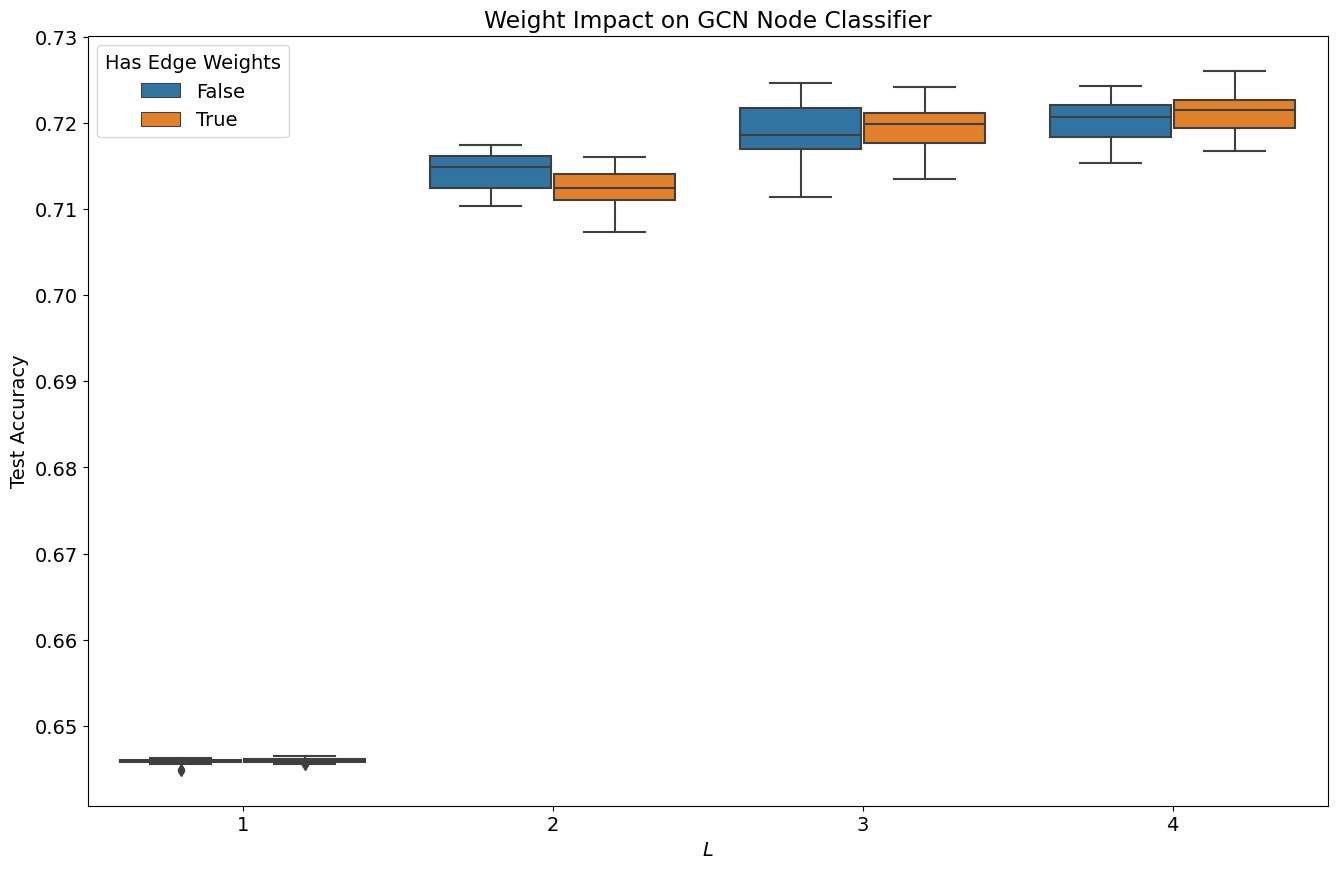

In [5]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

plt.title('Weight Impact on GCN Node Classifier')

sns.boxplot(
    data=best_epoch_metrics,
    x='n_layers',
    y='acc_test',
    hue='has_edge_weights')

plt.ylabel('Test Accuracy')
plt.xlabel('$L$')


# plt.yscale('log')
plt.legend(title='Has Edge Weights')
plt.savefig('reports/images/positional_graph_sage_weight_impact_gcn_node_classifier.pdf')

## T-test

In [6]:
report = {
    '$L$': [],
    'Weighted': [],
    'Unweighted': [],
    '$t$': [],
    'p-value': []
}

for n_layers in range(1, 5):
    a = best_epoch_metrics\
        .query(f'n_layers == {n_layers} & has_edge_weights == True')\
        ['acc_test']
        
    b = best_epoch_metrics\
        .query(f'n_layers == {n_layers} & has_edge_weights == False')\
        ['acc_test']
    ttest = ttest_ind(a, b)
    
    report['$L$'].append(f'${n_layers}$')
    report['Weighted'].append(f'${a.mean():.4} \pm {a.std():.2}$')
    report['Unweighted'].append(f'${b.mean():.4} \pm {b.std():.2}$')
    report['$t$'].append(f'${ttest.statistic:.4}$')
    report['p-value'].append(f'${ttest.pvalue:.4}$')
    
    
    print(f'with: {a.mean():.4} +- {a.std():.2}, '
          f'no: {b.mean():.4} +- {b.std():.4}, '
          f't: {ttest.statistic:.4}, pvalue: {ttest.pvalue:.4}')

with: 0.6459 +- 0.00021, no: 0.6458 +- 0.0003779, t: 1.185, pvalue: 0.2408
with: 0.7124 +- 0.0019, no: 0.7144 +- 0.002017, t: -3.782, pvalue: 0.0003707
with: 0.7196 +- 0.0026, no: 0.719 +- 0.003006, t: 0.8249, pvalue: 0.4128
with: 0.7212 +- 0.0023, no: 0.7203 +- 0.002408, t: 1.454, pvalue: 0.1512


In [7]:
print(pd.DataFrame(report).style.to_latex())

\begin{tabular}{llllll}
 & $L$ & Weighted & Unweighted & $t$ & p-value \\
0 & $1$ & $0.6459 \pm 0.00021$ & $0.6458 \pm 0.00038$ & $1.185$ & $0.2408$ \\
1 & $2$ & $0.7124 \pm 0.0019$ & $0.7144 \pm 0.002$ & $-3.782$ & $0.0003707$ \\
2 & $3$ & $0.7196 \pm 0.0026$ & $0.719 \pm 0.003$ & $0.8249$ & $0.4128$ \\
3 & $4$ & $0.7212 \pm 0.0023$ & $0.7203 \pm 0.0024$ & $1.454$ & $0.1512$ \\
\end{tabular}



## Epochs comparison

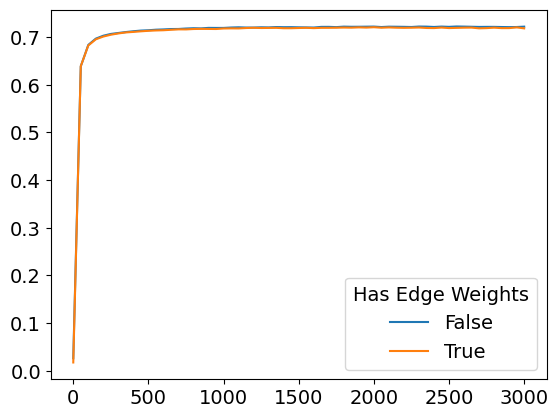

In [8]:
n_layers = 2
col = 'acc_val'

sub_df = metrics.query(f'n_layers == {n_layers}')

no_means = sub_df\
    .query('has_edge_weights == False')\
    .groupby('epoch')\
    [col]\
    .mean()

w_means = sub_df\
    .query('has_edge_weights == True')\
    .groupby('epoch')\
    [col]\
    .mean()

plt.plot(no_means, label='False')
plt.plot(w_means, label='True')

plt.legend(title='Has Edge Weights')
# plt.yscale('log')
# plt.xlim(200)
# plt.ylim(0.65, 0.75)